In [213]:
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch

# imports to load some data
from fours.utils.data_handling import load_adi_data

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.photometry import flux_ratio2mag, mag2flux_ratio

from pynpoint.util.analysis import fake_planet

# Load the data

In [2]:
dataset_file = Path("/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/09_new_rotation_loss/x2_different_residual_creations/")
exp_id = str("0123a")
use_rotation_loss = True
lambda_reg = float(850)

In [3]:
science_data, angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=str(dataset_file),
        data_tag="object_stacked_05",
        psf_template_tag="psf_template",
        para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

# other parameters
dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale = 0.02718

# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

In [4]:
dataset_id = "0115b"

# add the fake planet
fake_planet_config_file = "/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_" + exp_id + ".json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [463]:
fake_planet_config["flux_ratio"] = mag2flux_ratio(12.5)
fake_planet_config["separation"] = 30
fake_planet_config["planet_position"] = [0., 0., 30, 20.]

In [464]:
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template,
    parang=angles - np.pi/2, # the pi/2 is to correct the parang to the north
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

# Load the new code

In [465]:
from fours.position_flux.pca import PCANoiseModel
from fours.position_flux.negfc import NegFC

In [466]:
fake_planet_config["planet_position"][-1]

20.0

In [487]:
# create the NegFC model
negfc = NegFC(
    psf_template=psf_template,
    all_angles=angles,
    input_size=science_data.shape[1],
    init_separation=fake_planet_config["separation"],
    init_pos_angle=fake_planet_config["planet_position"][-1],
    init_flux_ratio=fake_planet_config["flux_ratio"],
    dit_science=dit_science,
    dit_psf_template=dit_psf_template,
    nd_factor=1.0,
    interpolation="bicubic",
)

In [488]:
pca_model = PCANoiseModel(
    angles=angles,
    image_shape=science_data.shape[1],
    pca_number=300,
    approx_svd=-1)

In [489]:
science_data_torch_with_planet = torch.tensor(data_with_fake_planet, dtype=torch.float32)
science_data_torch = torch.tensor(science_data, dtype=torch.float32)

In [490]:
# move everything to the GPU
negfc = negfc.to("cuda")
pca_model = pca_model.to("cuda")
science_data_torch = science_data_torch.to("cuda")
science_data_torch_with_planet = science_data_torch_with_planet.to("cuda")

In [491]:
after_negfc = negfc(science_data_torch_with_planet)

In [492]:
after_pca_with_planet = pca_model(science_data_torch_with_planet)
after_pca_neg_fc = pca_model(after_negfc)
after_pca_without_planet = pca_model(science_data_torch)

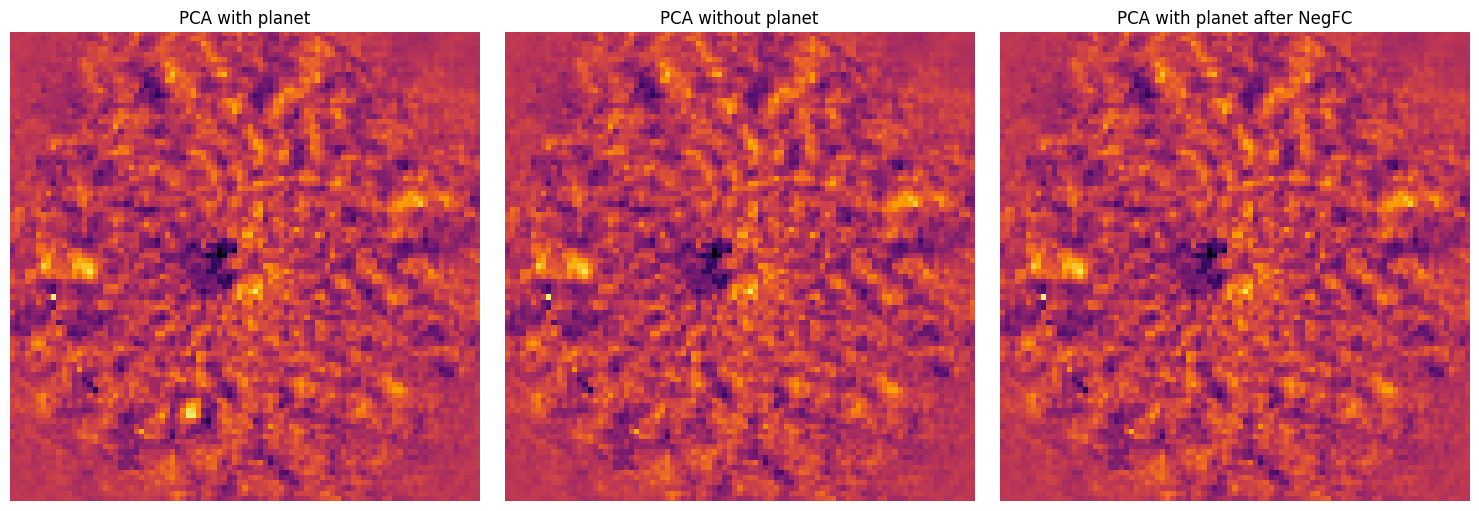

In [493]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(after_pca_with_planet.cpu().detach().numpy(), cmap="inferno", vmin=-0.5, vmax=0.5)
ax1.set_title("PCA with planet")
ax1.axis("off")

ax2.imshow(after_pca_without_planet.cpu().detach().numpy(), cmap="inferno", vmin=-0.5, vmax=0.5)
ax2.set_title("PCA without planet")
ax2.axis("off")

ax3.imshow(after_pca_neg_fc.cpu().detach().numpy(), cmap="inferno", vmin=-0.5, vmax=0.5)
ax3.set_title("PCA with planet after NegFC")
ax3.axis("off")

plt.tight_layout()

In [494]:
difference = after_pca_neg_fc.cpu().detach().numpy() - after_pca_without_planet.cpu().detach().numpy()

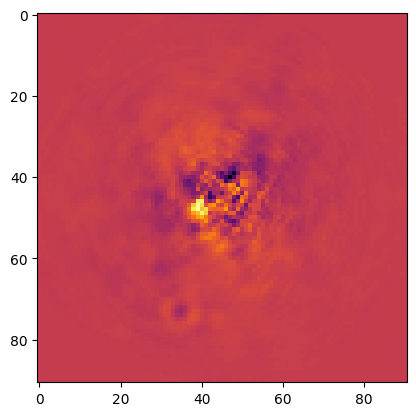

In [495]:
plt.imshow(difference, cmap="inferno")

In [496]:
np.max(difference)

0.030506074

In [497]:
np.max(np.abs(after_pca_with_planet.cpu().detach().numpy()))

0.5124546

# Implement a simple minimization

In [498]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


class NegFC(nn.Module):

    def __init__(
            self,
            psf_template,
            all_angles,
            input_size,
            init_separation,
            init_pos_angle,
            init_flux_ratio,
            dit_science,
            dit_psf_template,
            nd_factor,
            interpolation="bicubic"
    ):

        super(NegFC, self).__init__()
        self.m_input_size = input_size

        # initialize the three parameters
        self.pos_angle = nn.Parameter(torch.Tensor([init_pos_angle]))
        self.magnitude = nn.Parameter(torch.Tensor([flux_ratio2mag(init_flux_ratio)]))
        #self.flux_ratio = init_flux_ratio
        self.separation = nn.Parameter(torch.Tensor([init_separation]))
        self.interpolation = interpolation

        # the DIT and ND factor
        # TODO check if nd_factor is 1/nd_factor
        self.integration_time_factor = (
                dit_science / dit_psf_template * nd_factor)

        # save the angles
        self.register_buffer(
            "par_angles",
            torch.from_numpy(all_angles).float())

        # pad the psf template
        pad_size = (self.m_input_size - psf_template.shape[0]) // 2
        if pad_size < 0:
            raise ValueError(
                "The input size is smaller than the PSF template size")

        padded_psf = np.pad(
            psf_template,
            pad_width=((pad_size, pad_size), (pad_size, pad_size)),
            mode='constant',
            constant_values=0)

        self.register_buffer(
            "psf_template",
            torch.from_numpy(padded_psf).float())

    def get_forward_model(self):

        # calculate the correct position angle and x/y shifts
        ang = torch.deg2rad(self.pos_angle) + torch.pi / 2 - self.par_angles

        flux_ratio = 10 ** (-self.magnitude / 2.5)
        
        psf_torch = (self.psf_template *
                     flux_ratio *
                     self.integration_time_factor)

        x_shift = self.separation * torch.cos(ang)
        y_shift = self.separation * torch.sin(ang)

        # create the affine matrix
        theta = torch.zeros(ang.shape[0], 2, 3, device=ang.device)
        theta[:, 0, 0] = 1
        theta[:, 1, 1] = 1

        # the -1 is needed because the grid uses align_corners=True
        theta[:, 0, 2] = - x_shift / (psf_torch.shape[0] - 1) * 2
        theta[:, 1, 2] = - y_shift / (psf_torch.shape[1] - 1) * 2

        # build the grid
        grid = F.affine_grid(
            theta,
            torch.Size([ang.shape[0],
                        1,
                        self.m_input_size,
                        self.m_input_size]),
            align_corners=True)

        # apply the grid
        shifted_data = F.grid_sample(
            psf_torch.unsqueeze(0).unsqueeze(0).repeat(
                ang.shape[0], 1, 1, 1),
            grid,
            mode=self.interpolation,
            align_corners=True).squeeze()

        return shifted_data

    def forward(self, science_sequence):
        # get the forward model
        forward_model = self.get_forward_model()

        # apply the forward model
        return science_sequence - forward_model


In [499]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from fours.models.rotation import FieldRotationModel


class PCANoiseModel(nn.Module):

    def __init__(
            self,
            angles: np.ndarray,
            image_shape: int,
            pca_number: int,
            approx_svd: int = -1
    ):
        super(PCANoiseModel, self).__init__()

        # save the simple parameters
        self.m_pca_number = pca_number
        self.m_approx_svd = approx_svd
        self.m_image_shape = image_shape

        # create the rotation model
        self.rotation_model = FieldRotationModel(
            all_angles=angles,
            input_size=self.m_image_shape,
            subsample=1,
            inverse=False,
            register_grid=True)
        
        # create an empty basis
        self.register_buffer(
            "basis",
            torch.zeros(self.m_image_shape**2, self.m_pca_number))

    def compute_basis(
            self,
            images):

        # compute the PCA basis
        if self.m_approx_svd == -1:
            _, _, basis = torch.linalg.svd(images)
            basis = basis.T
        else:
            _, _, basis = torch.svd_lowrank(
                images, niter=1, q=self.m_approx_svd)
        
        # save the basis
        self.basis = basis.detach()

    def forward(self, images):
        # 1.) reshape images to fit for PCA
        images = images.view(images.shape[0],
                             images.shape[1] * images.shape[2])

        # 2.) remove the mean as needed for PCA
        images = images - images.mean(dim=0)

        # 3.) update the basis if needed
        #self.compute_basis(images)

        # 4.) compute PCA residuals
        pca_rep = torch.matmul(images, self.basis[:, :self.m_pca_number])
        noise_estimate = torch.matmul(pca_rep, self.basis[:, :self.m_pca_number].T)
        residual = images - noise_estimate
        residual_sequence = residual.view(
            images.shape[0],
            self.m_image_shape,
            self.m_image_shape)

        # 5.) rotate the frames
        rotated_frames = self.rotation_model(
            residual_sequence.unsqueeze(1).float(),
            parang_idx=torch.arange(len(residual_sequence))).squeeze(1)

        # 6.) average along the time axis
        return rotated_frames.mean(dim=0)


In [500]:
pca_model = PCANoiseModel(
    angles=angles,
    image_shape=science_data.shape[1],
    pca_number=300,
    approx_svd=5000)

In [501]:
# create the NegFC model
negfc = NegFC(
    psf_template=psf_template,
    all_angles=angles,
    input_size=science_data.shape[1],
    init_separation=fake_planet_config["separation"] + 2,
    init_pos_angle=fake_planet_config["planet_position"][-1] - 4,
    init_flux_ratio=mag2flux_ratio(12.0),
    dit_science=dit_science,
    dit_psf_template=dit_psf_template,
    nd_factor=1.0,
    interpolation="bicubic",)

In [502]:
# move everything to the GPU
science_data_torch_with_planet = science_data_torch_with_planet.to(0)
negfc = negfc.to(0)
pca_model = pca_model.to(0)

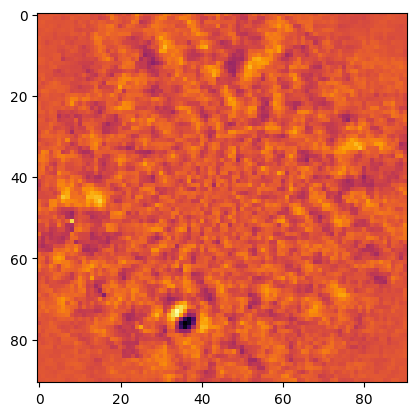

In [503]:
update_basis = True

after_negfc = negfc(science_data_torch_with_planet)

if update_basis:
    # 1.) reshape images to fit for PCA
    images = after_negfc.reshape(
        after_negfc.shape[0],
        after_negfc.shape[1] *
        after_negfc.shape[2])

    # 2.) remove the mean as needed for PCA
    images = images - images.mean(dim=0)

    # 3.) compute the basis
    pca_model.compute_basis(images)

after_pca_neg_fc = pca_model(after_negfc)
plt.imshow(after_pca_neg_fc.cpu().detach().numpy(), cmap="inferno")

In [504]:
from torch import optim
from tqdm import tqdm

In [505]:
input_data = science_data_torch_with_planet

# create the optimizer
optimizer_kwargs = {
    "max_iter": 20,
    "history_size": 10}

#optimizer_kwargs = {
 #   "lr": 1e-3}

optimizer = optim.LBFGS(
    negfc.parameters(),
    **optimizer_kwargs)

In [506]:
for j in range(20):
    print(negfc.separation.item(), negfc.pos_angle.item(), negfc.magnitude.item())
    after_negfc = negfc(science_data_torch_with_planet)
    
    # update the pca basis
    # 1.) reshape images to fit for PCA
    images = after_negfc.reshape(
        after_negfc.shape[0],
        after_negfc.shape[1] *
        after_negfc.shape[2])

    # 2.) remove the mean as needed for PCA
    images = images - images.mean(dim=0)

    # 3.) compute the basis
    pca_model.compute_basis(images)

    # iterate for 100 steps
    for i in range(20):
        def closure():        
            optimizer.zero_grad()
            after_negfc = negfc(science_data_torch_with_planet)
            after_pca_neg_fc = pca_model(after_negfc)
            loss = torch.sum(after_pca_neg_fc**2)
            loss.backward()

            # print all parameters and the loss
            #print(negfc.separation.item(), np.rad2deg(negfc.pos_angle.item()), loss.item())
            return loss

        optimizer.step(closure)

32.0 16.0 12.0
31.660701751708984 17.32573127746582 12.622220993041992
30.88031005859375 19.21461296081543 12.834053993225098
30.364177703857422 20.0434627532959 12.6891450881958
30.12959098815918 20.308931350708008 12.551864624023438
30.01468849182129 20.392393112182617 12.465727806091309
29.952381134033203 20.418100357055664 12.413987159729004
29.916292190551758 20.424776077270508 12.382896423339844
29.89479637145996 20.425518035888672 12.364084243774414
29.88181495666504 20.423891067504883 12.35279655456543
29.87372398376465 20.422704696655273 12.345854759216309
29.868785858154297 20.42153549194336 12.34168815612793
29.865636825561523 20.42009735107422 12.339049339294434
29.863737106323242 20.419626235961914 12.337565422058105
29.862564086914062 20.419544219970703 12.33665657043457
29.861848831176758 20.419544219970703 12.335966110229492
29.86142349243164 20.419218063354492 12.335553169250488
29.861047744750977 20.418909072875977 12.33539867401123
29.860897064208984 20.4188594818115

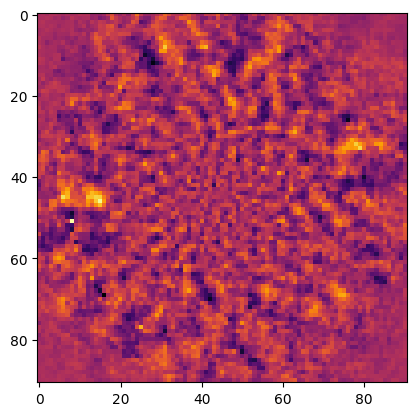

In [507]:
after_negfc = negfc(science_data_torch_with_planet)
after_pca_neg_fc = pca_model(after_negfc)
plt.imshow(after_pca_neg_fc.cpu().detach().numpy(), cmap="inferno")

In [508]:
negfc.separation.item()

29.860797882080078

In [509]:
negfc.pos_angle.item()

20.41872215270996

In [510]:
negfc.magnitude.item()

12.33515739440918

In [511]:
x_shift_res = negfc.separation.item() * np.cos(np.deg2rad(negfc.pos_angle.item()))
y_shift_res = negfc.separation.item() * np.sin(np.deg2rad(negfc.pos_angle.item()))

print(x_shift_res, y_shift_res)

27.984585392177554 10.417784341325207


In [512]:
x_shift = 30 * np.cos(np.deg2rad(20))
y_shift = 30 * np.sin(np.deg2rad(20))

print(x_shift, y_shift)

28.19077862357725 10.260604299770064


In [513]:
np.abs(y_shift - y_shift_res)

0.15718004155514365

In [514]:
np.abs(x_shift - x_shift_res)

0.2061932313996948

In [515]:
brightness_diff = np.abs(mag2flux_ratio(12.5) - mag2flux_ratio(negfc.magnitude.item()))

In [516]:
brightness_diff / mag2flux_ratio(12.5)

0.16395728340418966